In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers
from freestyl.supervised.siamese.features.model import SiameseFeatureModule
from freestyl.supervised.siamese import get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_FW = True
LR = 1e-3
LOSS = "linearManhattan"
CHRYSOSTOM = False
SAMPLE = False
DYDIMUS = True

if USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 32
else:
    SIZE = 64

seed = 42
IGNORE_KEYS = [
    "file", "author", "textgroup", "title", "tokens", "length", "modified_text"
]
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    return filename
    

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
def get_train_dev_test(filtre, seed=42, ratio=10):
    test = len(filtre) * ratio // 100
    dev_and_test = test * 2
    print(f"Train categorical samples: {len(filtre)-dev_and_test}")
    print(f"Dev   categorical samples: {dev_and_test-test}")
    print(f"Test  categorical samples: {test}")
    r = random.Random(seed)
    r.shuffle(filtre)
    return filtre[:-dev_and_test], filtre[-dev_and_test:-test], filtre[-test:]


train = pd.read_csv("tlg-train.csv")
dev = pd.read_csv("tlg-dev.csv")
test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not DYDIMUS:
    train = train[~train.author.str.contains("Didym")]
    dev = dev[~dev.author.str.contains("Didym")]
    test = test[~test.author.str.contains("Didym")]
    
train = train[~train.title.str.contains("Comment")]
dev = dev[~dev.title.str.contains("Comment")]
test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1266, 2108)
Dev Shape : (141, 2108)
Test Shape : (158, 2107)


In [3]:
train.title.unique().shape

(383,)

<AxesSubplot:>

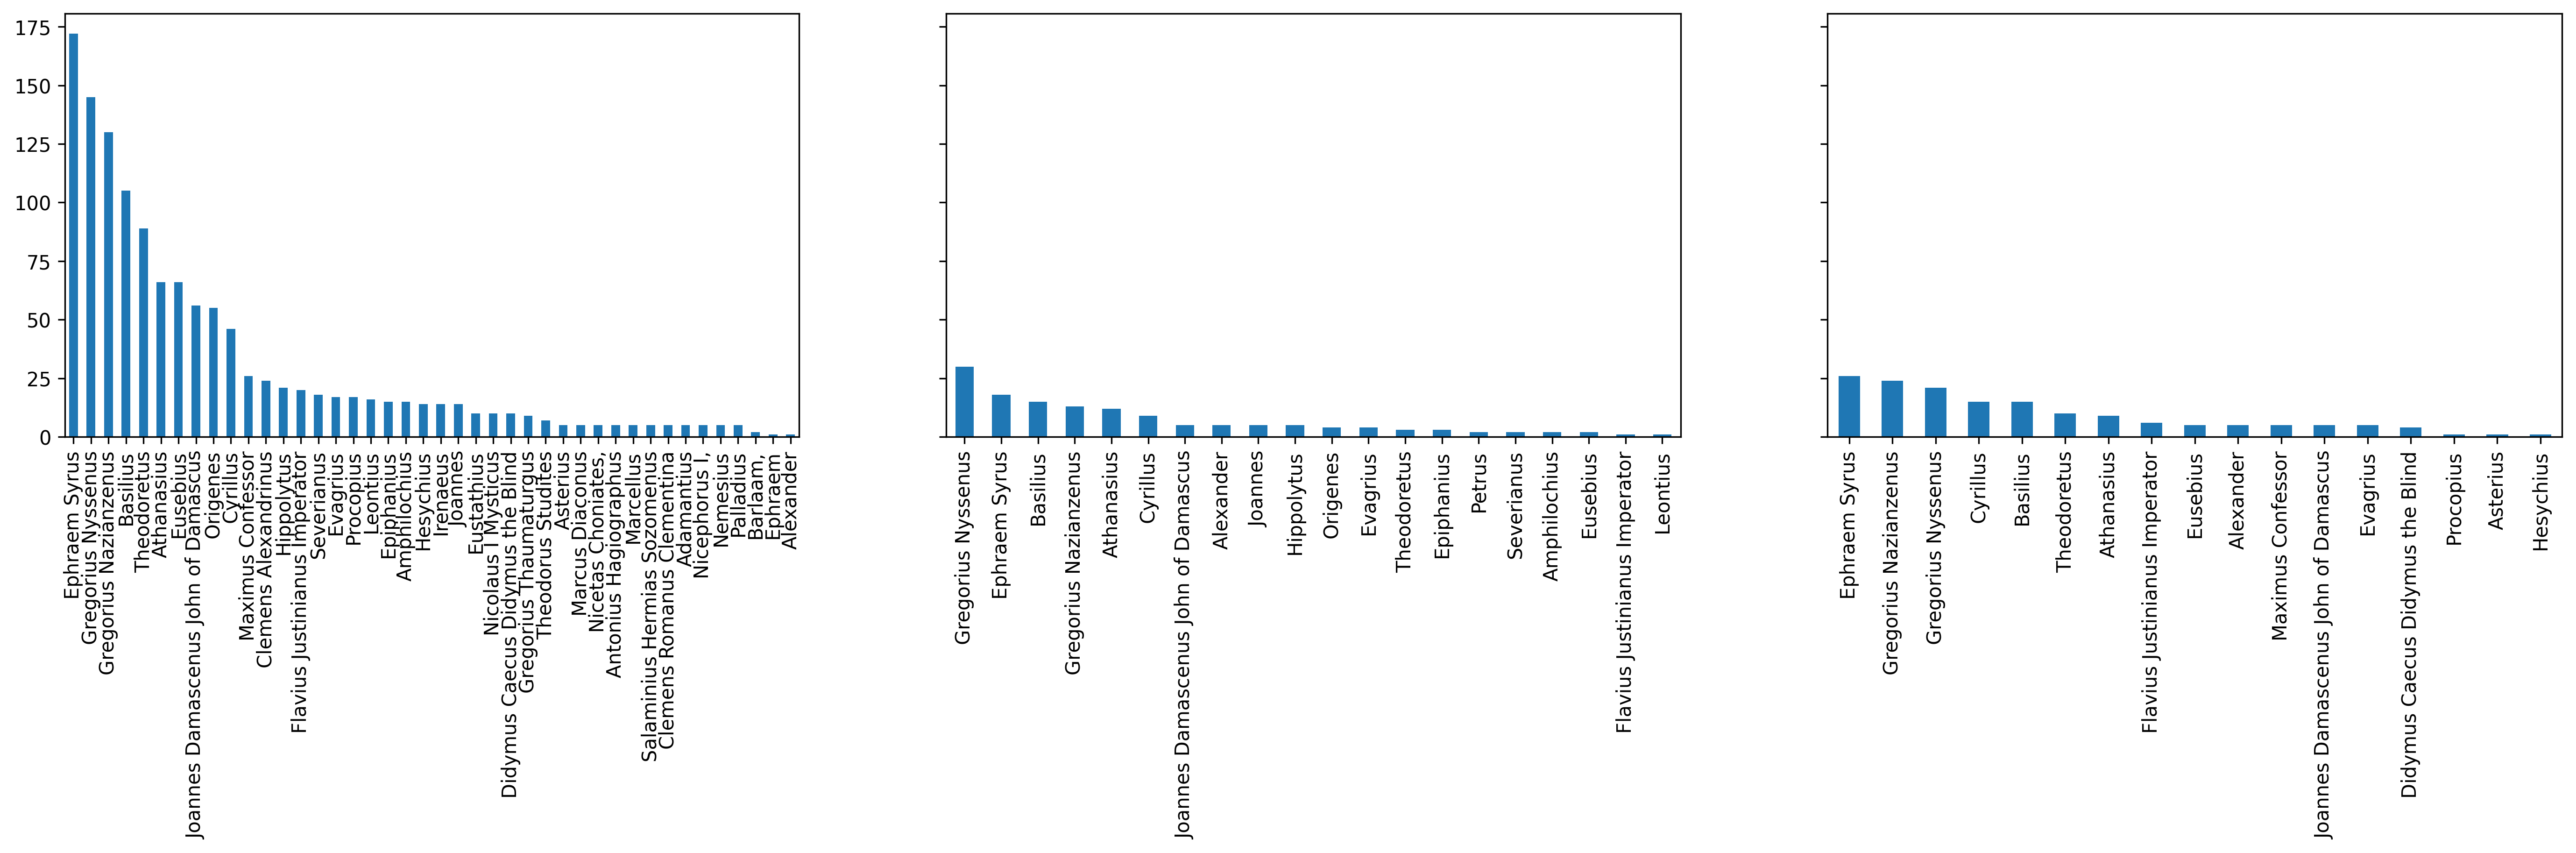

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
# fig.savefig(make_file_name("samples.png"))

## Util functions

In [5]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col="Distance", noprint=False) -> None:
    scores["Attribution"] = scores[col] <= distance
    tp = scores[scores.IsAPair].Attribution.sum() 
    fp = scores[~scores.IsAPair].Attribution.sum()
    fn = abs(scores[scores.IsAPair].Attribution.shape[0] - tp)
    tn = abs(fp - scores[~scores.IsAPair].Attribution.shape[0])
    if not noprint:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Automatically retrieve some constant parameters

In [6]:
POS_COLS = [
    col
    for col in train.columns
    if col.startswith("$POS$")
]
FW_COLS = [
    col
    for col in train.columns
    if col.startswith("$MFW$")
]
IGNORE = set(IGNORE_KEYS + (
    POS_COLS if not USE_POS else []
) + (
    FW_COLS if not USE_FW else [])
)

## Get DataFrameWrapper

In [7]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
data_dev.update_features(data.features)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
data_test.update_features(data.features)
assign_normalization(data_test)
data._x_ignore

2101 new features found, setting them as 0.


('title', 'file', 'textgroup', 'modified_text', 'length', 'author', 'tokens')

## CHecking some details

In [8]:
data.normalized.xs.head()

,Unnamed: 0,$POS$v-n-v,$POS$v-c-d,$POS$d-l-n,$POS$l-n-n,$POS$d-n-v,$POS$n-v-l,$POS$l-l-n,$POS$n-n-v,$POS$n-v-n,...,$TRI$σῶμ,$TRI$οἷο,$TRI$λῳ_,$TRI$_ἤγ,$TRI$ἁπλ,$TRI$_λύ,$TRI$ἐνδ,$TRI$_λυ,$TRI$λεγ,$TRI$εἴρ
0,0,0.001786,0.010714,0.012500,0.017857,0.010714,0.017857,0.008929,0.008929,0.003571,...,0.000268,0.000000,0.000268,0.000000,0.000268,0.000268,0.000268,0.000000,0.000000,0.0
3,3,0.002519,0.005038,0.015113,0.015113,0.002519,0.022670,0.005038,0.002519,0.007557,...,0.000000,0.000279,0.000279,0.000000,0.000279,0.000000,0.000279,0.000000,0.000000,0.0
5,5,0.007018,0.001754,0.010526,0.021053,0.001754,0.024561,0.001754,0.012281,0.001754,...,0.000279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000558,0.001116,0.0
6,6,0.000000,0.003992,0.007984,0.021956,0.000000,0.017964,0.009980,0.013972,0.003992,...,0.000000,0.000000,0.000000,0.000278,0.000000,0.000000,0.000000,0.000000,0.000555,0.0
7,7,0.005894,0.015717,0.013752,0.011788,0.005894,0.009823,0.007859,0.011788,0.005894,...,0.000000,0.000275,0.000000,0.000000,0.000000,0.000000,0.000275,0.000275,0.000824,0.0


## Training

In [9]:
models = SiameseFeatureModule.load_from_checkpoint("lightning_logs/version_579/checkpoints/epoch=205-step=4120.ckpt") 

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [10]:
models.eval()

SiameseFeatureModule(
  (aucroc): AUROC()
  (distance): SNRDistance()
  (loss_func): SignalToNoiseRatioContrastiveLoss(
    (distance): SNRDistance()
    (reducer): MultipleReducers(
      (reducers): ModuleDict(
        (pos_loss): AvgNonZeroReducer()
        (neg_loss): AvgNonZeroReducer()
      )
      (default_reducer): MeanReducer()
    )
  )
  (miner): BatchEasyHardMiner(
    (distance): SNRDistance()
  )
  (encoder): Sequential(
    (0): BatchNorm1d(2101, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2101, out_features=64, bias=True)
  )
)

### Get first FP distance

In [11]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.9322355048230766


In [12]:
scores[~scores.IsAPair].sort_values("Probability").tail()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
901961,Theodoretus,Theodoretus - Historia ecclesiastica,Origenes,Origenes - Homiliae in Lucam,0.422237,0.577763,True,False,0
901941,Theodoretus,Theodoretus - Historia ecclesiastica,Origenes,Origenes - Homiliae in Lucam,0.387109,0.612891,True,False,0
20993,Origenes,Origenes - Homiliae in Ezechielem,Theodoretus,Theodoretus - Historia ecclesiastica,0.365940,0.634060,True,False,0
20973,Origenes,Origenes - Homiliae in Ezechielem,Theodoretus,Theodoretus - Historia ecclesiastica,0.344668,0.655332,True,False,0
821738,Theodoretus,Theodoretus - Historia ecclesiastica,Origenes,Origenes - Homiliae in Ezechielem,0.333619,0.666381,True,False,0


In [13]:
len(set(scores.ComparedClass.unique() + scores.ComparatorClass.unique()))

42

## Evaluating Dev for Test Threshold

In [14]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.8155524150953559


In [15]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Probability").tail()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
6482,Gregorius Nyssenus,Gregorius Nyssenus - Oratio catechetica magna,Basilius,Basilius - Homiliae in hexaemeron,0.554854,0.445146,False,False,0
7794,Gregorius Nyssenus,Gregorius Nyssenus - Vita sanctae Macrinae,Basilius,Basilius - Homiliae in hexaemeron,0.550573,0.449427,False,False,0
7798,Gregorius Nyssenus,Gregorius Nyssenus - Vita sanctae Macrinae,Basilius,Basilius - De spiritu sancto,0.534588,0.465412,False,False,0
6960,Gregorius Nyssenus,Gregorius Nyssenus - De virginitate,Basilius,Basilius - Homiliae in hexaemeron,0.509342,0.490658,False,False,0
19655,Ephraem Syrus,Ephraem Syrus - De iudicio et compunctione,Amphilochius,Amphilochius - De recens baptizatis (orat. 7),0.414623,0.585377,True,False,0


In [16]:
len(set(dev_pairs.ComparedLabel.unique() + dev_pairs.ComparatorLabel.unique()))

49

<AxesSubplot:>

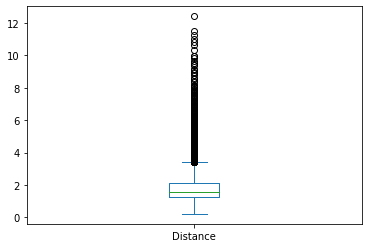

In [17]:
dev_pairs.Distance.plot.box()

In [18]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

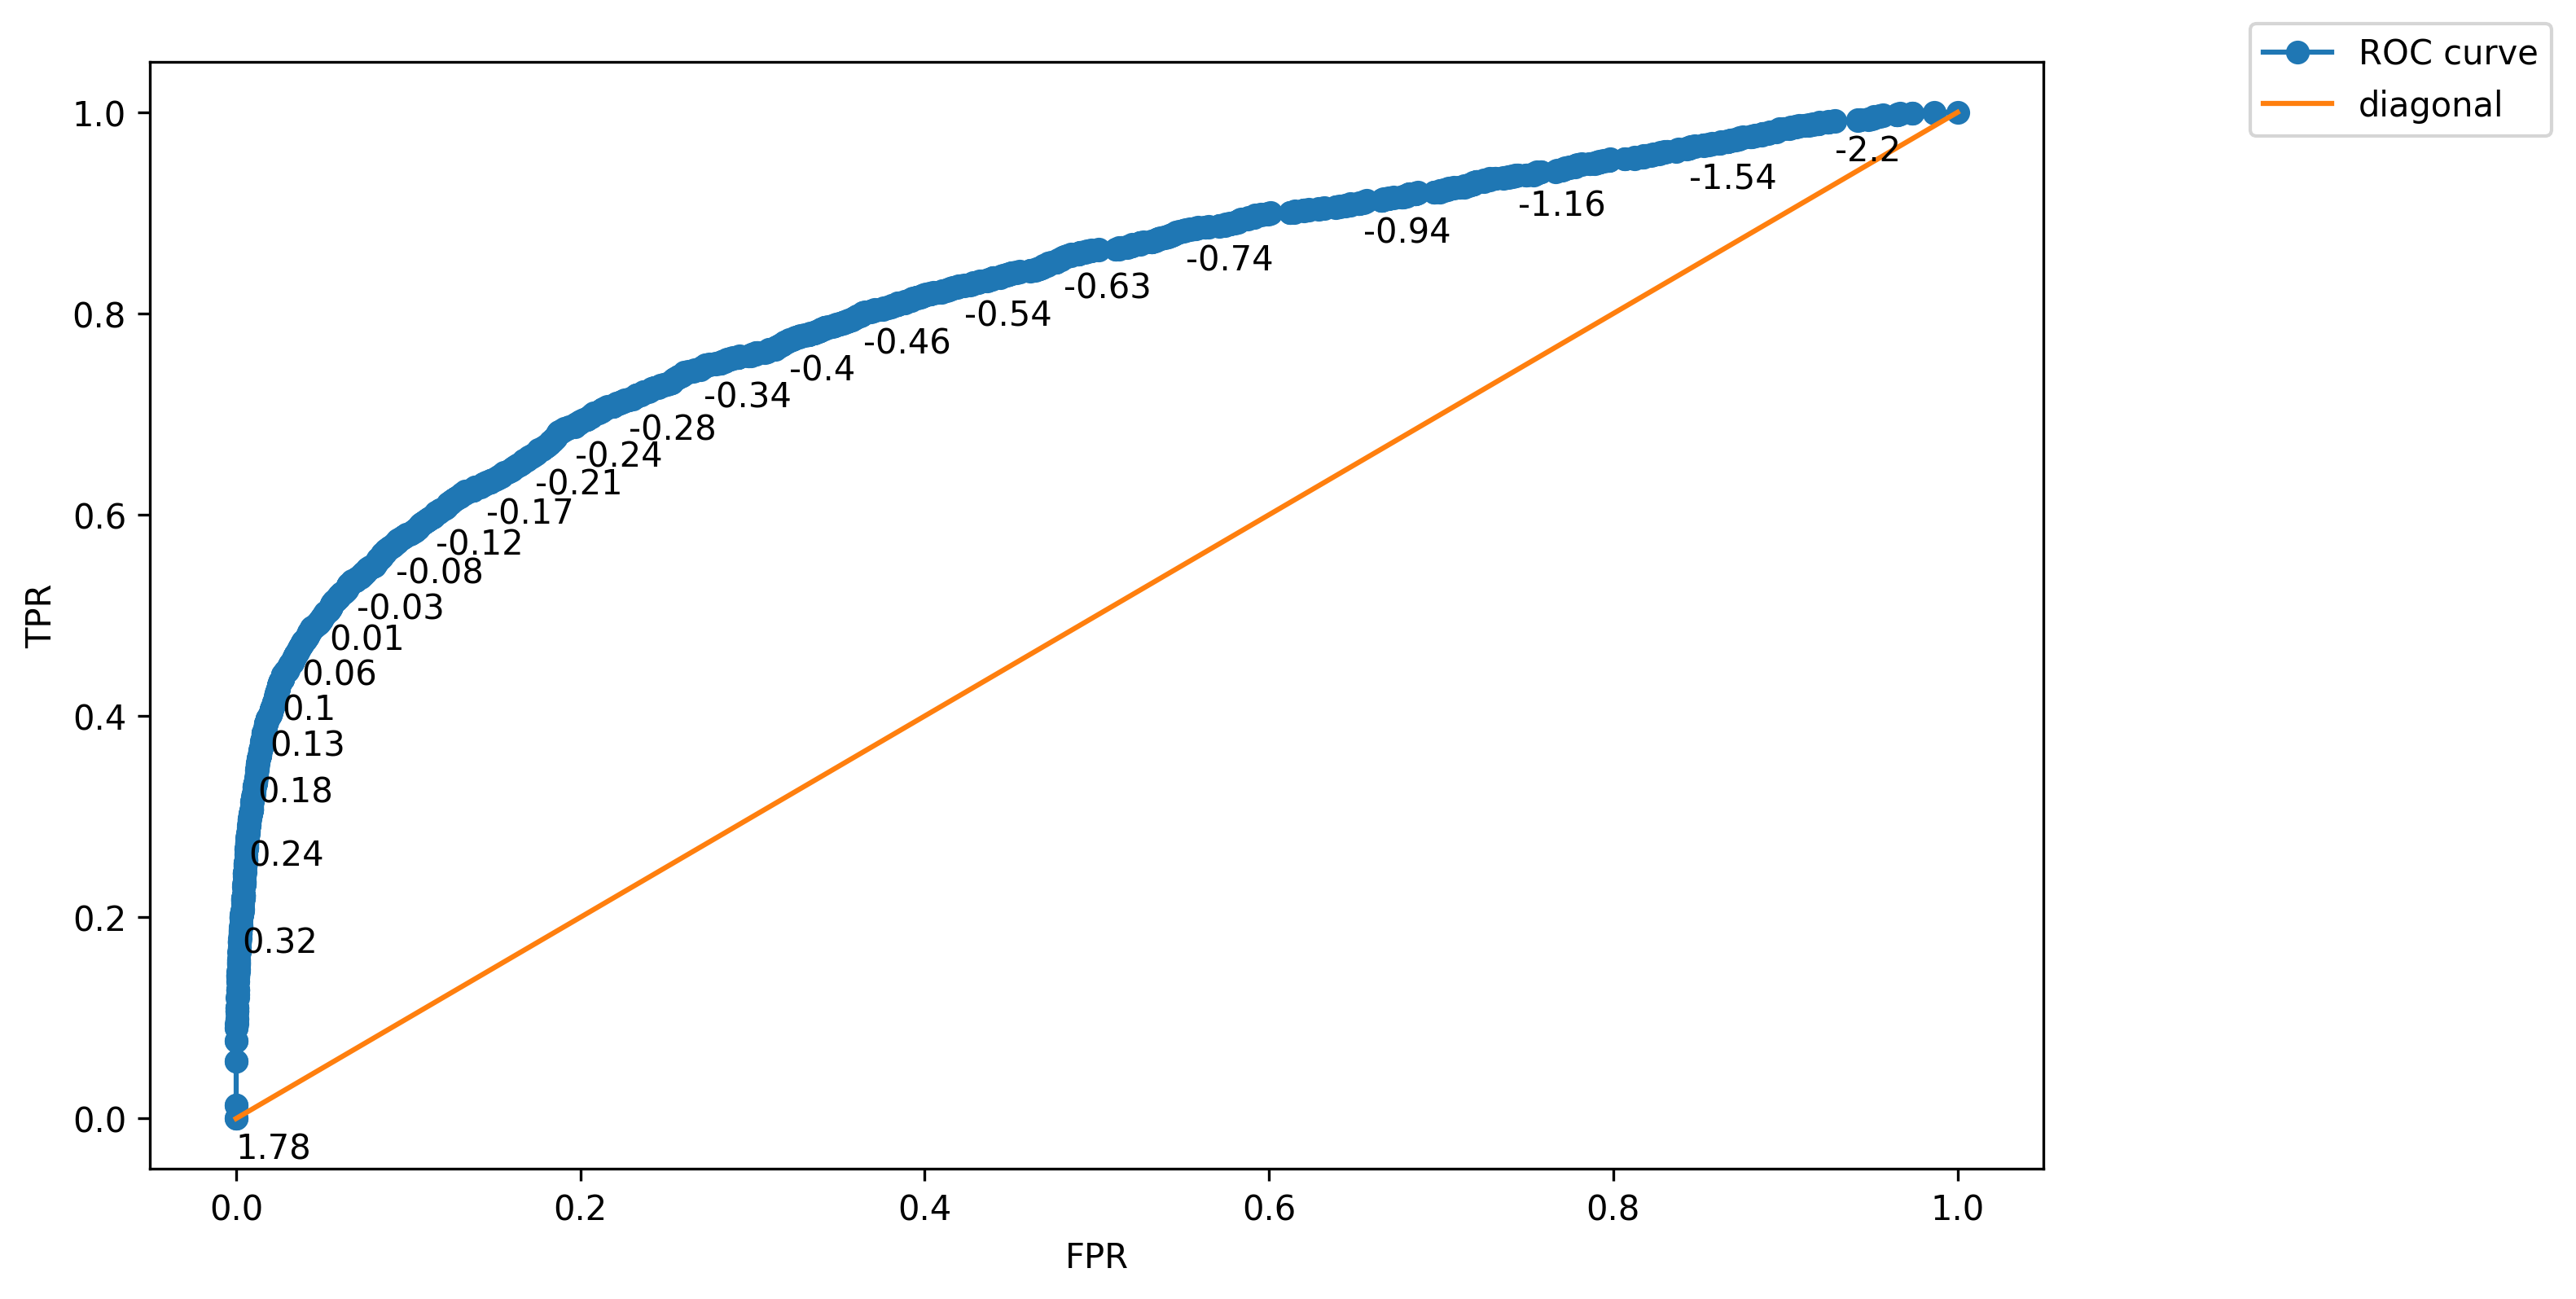

In [19]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs.Probability, nth=100, is_dist=False)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
# plt.gcf().savefig(make_file_name("aucroc-dev.png"))

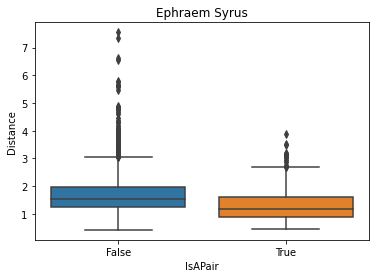

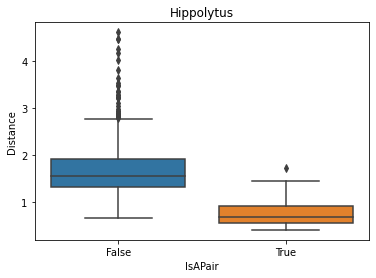

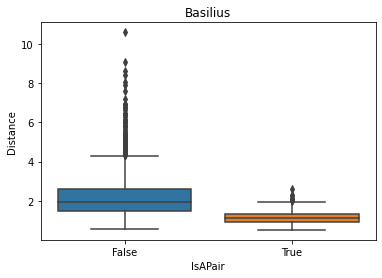

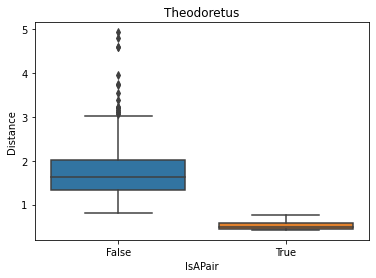

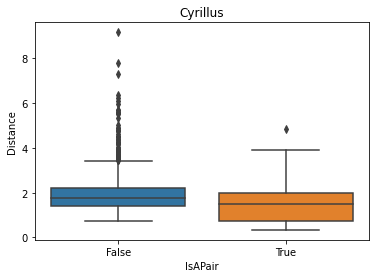

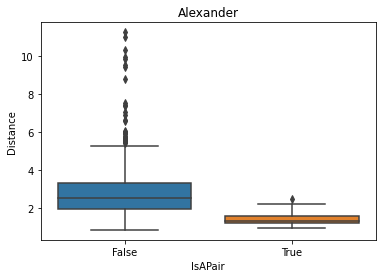

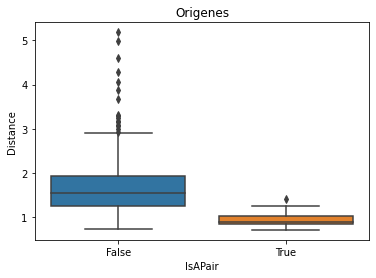

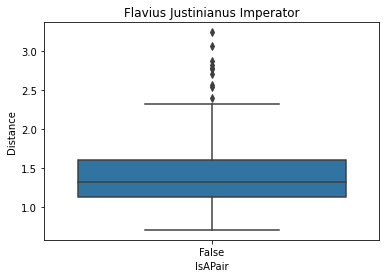

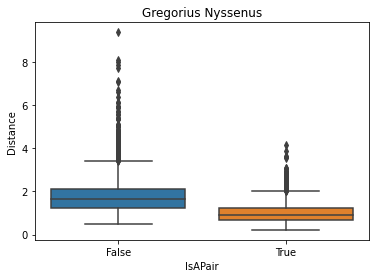

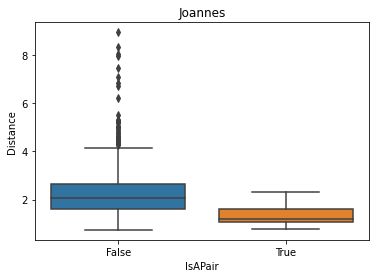

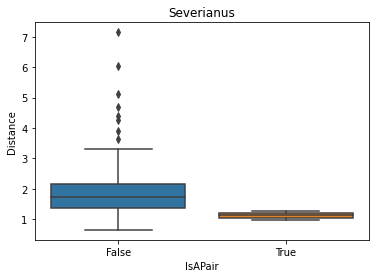

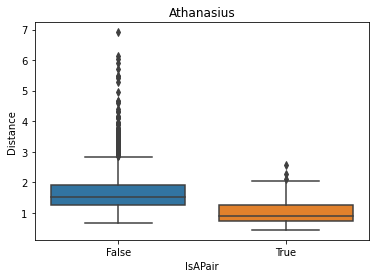

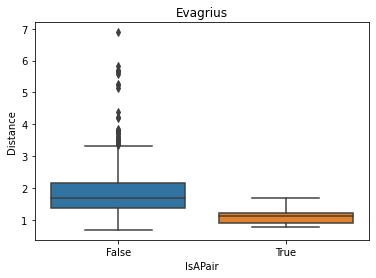

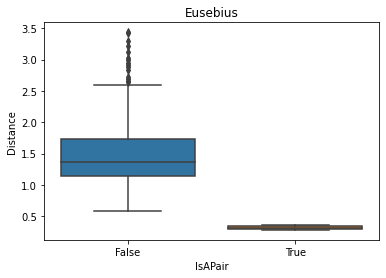

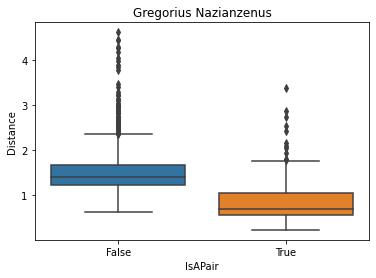

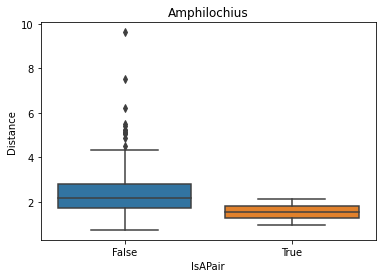

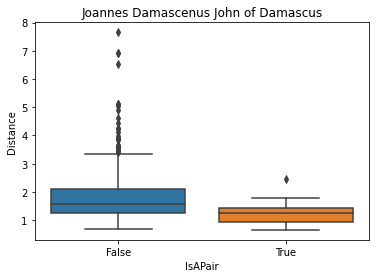

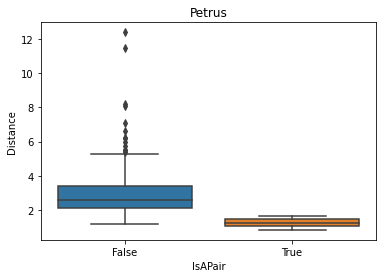

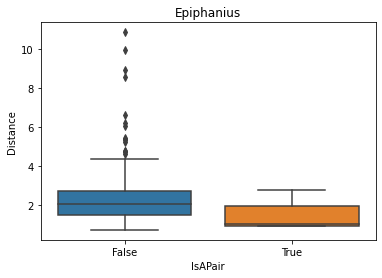

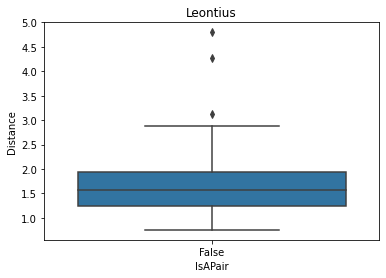

In [20]:
for cls in dev_pairs.ComparedClass.unique():
    plt.figure()
    sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y="Distance")
    plt.gca().set_title(cls)
#     plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [21]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

True positives: 1870
False Negative 0
True Negative 98
False positives: 17772
Accuracy: 1.00

===
Without sampling
===

True positives: 1474
False Negative 0
True Negative 98
False positives: 17772
Accuracy: 1.00


/tmp/ipykernel_37390/2851406731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(1474, 17772, 98, 0)

## Evaluating Test with Dev Threshold

In [22]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [23]:
# test_pairs[~test_pairs.IsAPair].sort_values("Distance").head()
test_pairs[~test_pairs.IsAPair].sort_values("Probability").tail()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
9166,Gregorius Nazianzenus,Gregorius Nazianzenus - Funebris in laudem Cae...,Basilius,Basilius - De legendis gentilium libris,0.596965,0.403035,True,False,0
7147,Flavius Justinianus Imperator,Flavius Justinianus Imperator - Contra monophy...,Theodoretus,Theodoretus - Epistulae: Collectio Sirmondiana...,0.588694,0.411306,True,False,0
22036,Gregorius Nazianzenus,Gregorius Nazianzenus - Funebris oratio in pat...,Basilius,Basilius - De legendis gentilium libris,0.583696,0.416304,True,False,0
22111,Flavius Justinianus Imperator,Flavius Justinianus Imperator - Contra monophy...,Athanasius,Athanasius - De synodis Arimini in Italia et S...,0.527449,0.472551,True,False,0
10257,Flavius Justinianus Imperator,Flavius Justinianus Imperator - Contra monophy...,Athanasius,Athanasius - De synodis Arimini in Italia et S...,0.386301,0.613699,True,False,0


In [24]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

ROC: 0.8416388251843383
True positives: 2346
False Negative 0
True Negative 142
False positives: 22318
Accuracy: 1.00

===
Without sampling
===

True positives: 1816
False Negative 0
True Negative 142
False positives: 22318
Accuracy: 1.00


/tmp/ipykernel_37390/2851406731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(1816, 22318, 142, 0)

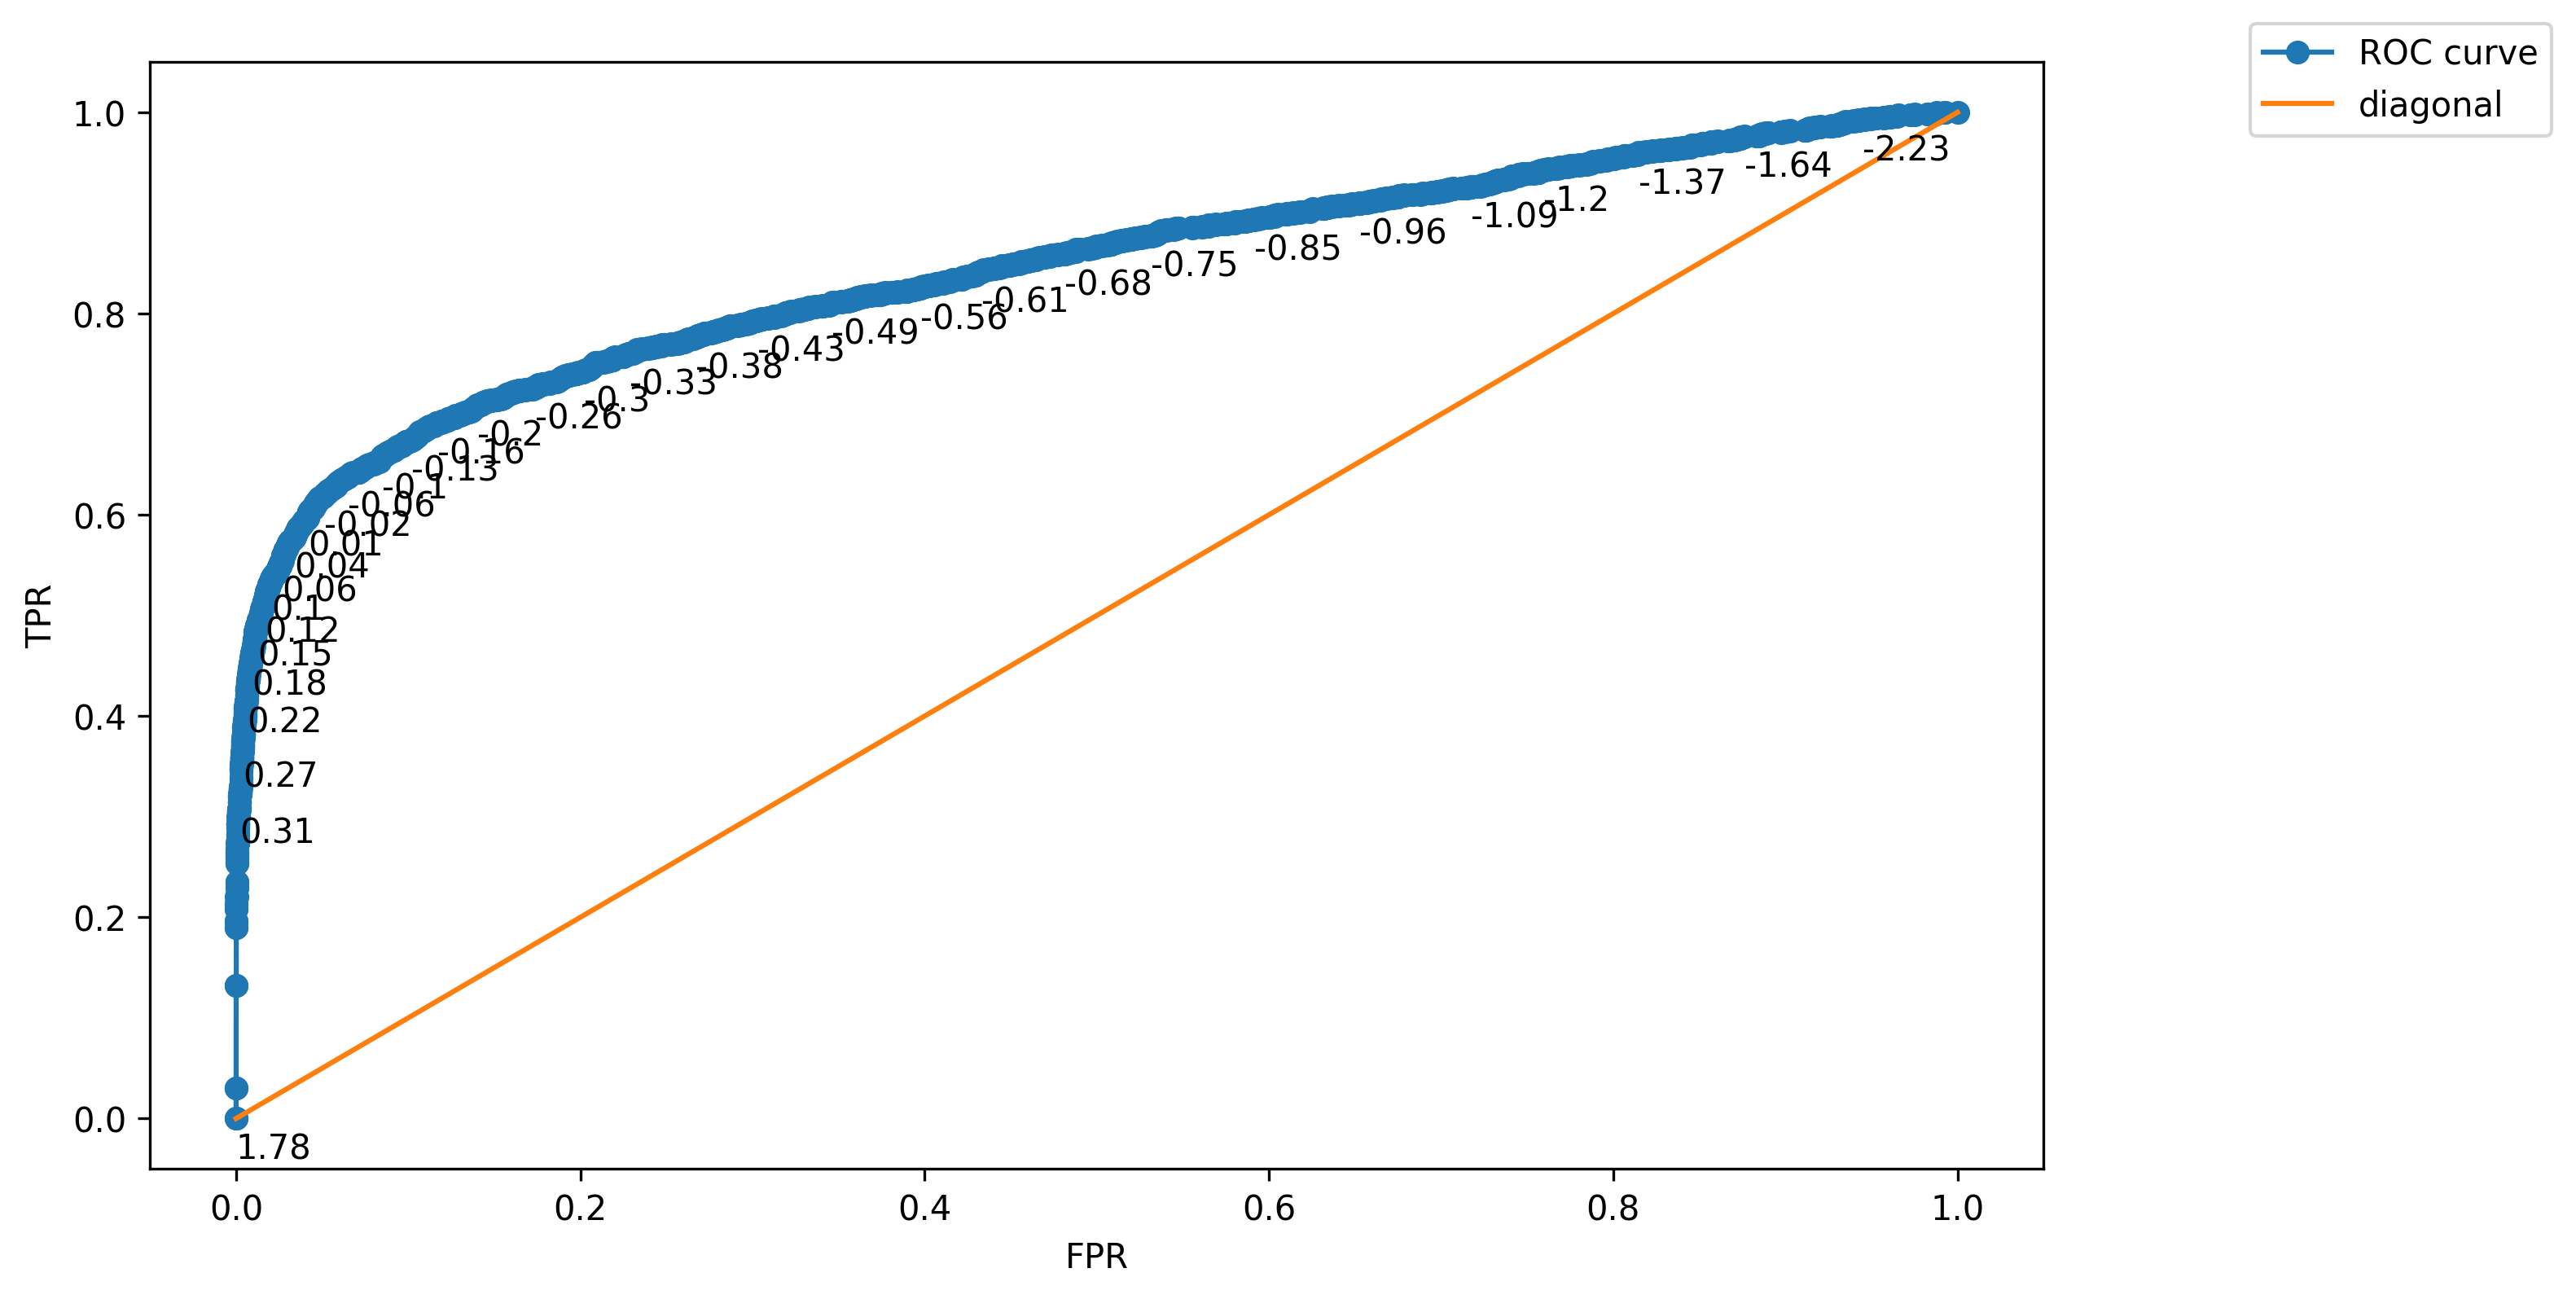

In [25]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs.Probability, nth=75, is_dist=False)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
#plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [26]:
len(set(test_pairs.ComparedClass.unique().tolist() + test_pairs.ComparatorClass.unique().tolist()))

17

In [27]:
# dev_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [28]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=[col for col in df.columns if col not in data.features])
#
print(len(DFW.features))
print(len(data.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

2059
2101
2101 new features found, setting them as 0.
2101
2101


In [29]:
models.eval()
pairs = get_df_prediction(trainer, model=models, compared=DFW, threshold=MAX_DISTANCE)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [30]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.head()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
0,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC13,PC13 - InVenerabilemCrucem,1.675787,-0.675787,True,False,0
1,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PCX,PCX - DeJenunioSermo5B,3.716083,-2.716083,True,False,0
2,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC6,PC6 - DePoenintentiaSermo1,1.493611,-0.493611,True,False,0
3,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC16,PC16 - InIlludSiQuaChristoaNovaCreatura,1.566139,-0.566139,True,False,0
4,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC8,PC8 - DePatientiaSermo1,1.395356,-0.395356,True,False,0


In [31]:
pairs["RoundedDistance"] = pairs.Distance.round(2)
dists = sorted(pairs["RoundedDistance"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1

for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col="Distance", noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs.RoundedDistance == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col="Distance", noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs.RoundedDistance == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    

In [32]:
pairs[(pairs.TestPre >= .90) & (pairs.IsAPair)].sort_values(["DevFP", "TestFP", "Distance"])

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K,RoundedDistance,...,TestFN,TestTP,TestTN,DevTPR,DevPre,DevFPR,DevFP,DevFN,DevTP,DevTN
294,PC16,PC16 - InIlludSiQuaChristoaNovaCreatura,PC16,PC16 - InPsalmum50Homilia1,0.236556,0.763444,True,True,0,0.24,...,2345,1,22460,0.001070,1.000000,0.000000,0,1868,2,17870
1083,PC7,PC7 - DeIeiunoSermo3,PC7,PC7 - DeIeiunoSermo5,0.237403,0.762597,True,True,0,0.24,...,2345,1,22460,0.001070,1.000000,0.000000,0,1868,2,17870
308,PC16,PC16 - InIlludSiQuaChristoaNovaCreatura,PC16,PC16 - InIlludSufficitTibiGratiaMea,0.248028,0.751972,True,True,0,0.25,...,2342,4,22460,0.001070,1.000000,0.000000,0,1868,2,17870
1608,PC16,PC16 - InPsalmum50Homilia1,PC16,PC16 - InIlludSufficitTibiGratiaMea,0.271928,0.728072,True,True,0,0.27,...,2340,6,22460,0.001070,1.000000,0.000000,0,1868,2,17870
3498,PC7,PC7 - DeIeiunoSermo5,PC7,PC7 - DeIeiunoSermo3,0.286685,0.713315,True,True,0,0.29,...,2337,9,22460,0.002674,1.000000,0.000000,0,1865,5,17870
756,PC7,PC7 - DeIeiunoSermo2,PC7,PC7 - DeIeiunoSermo5,0.295998,0.704002,True,True,0,0.30,...,2334,12,22460,0.003209,1.000000,0.000000,0,1864,6,17870
1982,PC16,PC16 - InPsalmum50Homilia2,PC16,PC16 - InIlludSufficitTibiGratiaMea,0.299318,0.700682,True,True,0,0.30,...,2334,12,22460,0.003209,1.000000,0.000000,0,1864,6,17870
4023,PC16,PC16 - InIlludSufficitTibiGratiaMea,PC16,PC16 - InPsalmum50Homilia1,0.302833,0.697167,True,True,0,0.30,...,2334,12,22460,0.003209,1.000000,0.000000,0,1864,6,17870
1605,PC16,PC16 - InPsalmum50Homilia1,PC16,PC16 - InPsalmum50Homilia2,0.303744,0.696256,True,True,0,0.30,...,2334,12,22460,0.003209,1.000000,0.000000,0,1864,6,17870
4020,PC16,PC16 - InPsalmum50Homilia2,PC16,PC16 - InPsalmum50Homilia1,0.310609,0.689391,True,True,0,0.31,...,2333,13,22460,0.003209,1.000000,0.000000,0,1864,6,17870


In [37]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))

## Visualize

In [34]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)

# We first get the wonderful classes of compared
dev_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_dev, model=models, batch_size=8))
)
dev_vectors = torch.cat([vec.cpu() for vec in dev_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_dev.get_labels(), data_dev.ys.tolist(), dev_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [35]:
# We first get the wonderful classes of compared
test_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_test, model=models, batch_size=8))
)
test_vectors = torch.cat([vec.cpu() for vec in test_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_test.get_labels(), data_test.ys.tolist(), test_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [36]:
# We first get the wonderful classes of compared
#pcs, _ = zip(
#    *trainer.predict(models, make_dataloader(DFW, model=models, batch_size=8))
#)
#pcs = torch.cat([vec.cpu() for vec in pcs], dim=0)


for label, vector in zip(DFW.get_labels(), pcs.tolist()):
    author, label = label.split(" - ")
    dataframe.append((author, label, *vector))

NameError: name 'pcs' is not defined

In [ ]:
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df

In [ ]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("genre-dev.html"))